In [1]:
# Manejo de dataframes y series
import pandas as pd
# Librerías para generación de gráficos
import matplotlib.pyplot as plt
import seaborn as sns


#Create a SparkSession object
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('secop').getOrCreate()

from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import regexp_replace
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
spark.sparkContext.setLogLevel("ERROR")


Picked up _JAVA_OPTIONS: -Xmx12288m
Picked up _JAVA_OPTIONS: -Xmx12288m
23/05/16 21:40:17 WARN Utils: Your hostname, joanPC resolves to a loopback address: 127.0.1.1; using 192.168.1.201 instead (on interface wlo1)
23/05/16 21:40:17 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/16 21:40:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/05/16 21:40:18 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
sdf = spark.read.options(inferSchema='True',
              header='True').csv('SECOP_1_.csv')

In [3]:
sdf.printSchema()

root
 |-- UID: string (nullable = true)
 |-- Anno Cargue SECOP: string (nullable = true)
 |-- Anno Firma del Contrato: integer (nullable = true)
 |-- Nivel Entidad: string (nullable = true)
 |-- Orden Entidad: string (nullable = true)
 |-- Nombre de la Entidad: string (nullable = true)
 |-- NIT de la Entidad: string (nullable = true)
 |-- Código de la Entidad: string (nullable = true)
 |-- ID Tipo de Proceso: integer (nullable = true)
 |-- Tipo de Proceso: string (nullable = true)
 |-- Estado del Proceso: string (nullable = true)
 |-- Causal de Otras Formas de Contratacion Directa: string (nullable = true)
 |-- ID Regimen de Contratacion: integer (nullable = true)
 |-- Regimen de Contratacion: string (nullable = true)
 |-- ID Objeto a Contratar: integer (nullable = true)
 |-- Objeto a Contratar: string (nullable = true)
 |-- Detalle del Objeto a Contratar: string (nullable = true)
 |-- Tipo de Contrato: string (nullable = true)
 |-- Municipio Obtencion: string (nullable = true)
 |-- Mu

In [4]:
data_2=sdf.select('UID','Tipo de Proceso',
        'Objeto a Contratar',
      'Tipo de Contrato',
       'Nombre Grupo', 'Nombre Clase',
        'Nombre de la Entidad',
       'Plazo de Ejec del Contrato', 'Rango de Ejec del Contrato',
       'Cuantia Contrato','Valor Total de Adiciones',
       'Origen de los Recursos',  'Municipio Entidad', 'Departamento Entidad'
        )

In [7]:
data_2.select('Nombre de la Entidad').show(truncate=False)

+---------------------------------------------------------------------------------------+
|Nombre de la Entidad                                                                   |
+---------------------------------------------------------------------------------------+
|ARAUCA  ESE MORENO Y CLAVIJO  ARAUCA                                                   |
|ANTIOQUIA  ALCALDÍA MUNICIPIO DE HELICONIA                                             |
|MAGDALENA  PERSONERÍA MUNICIPIO DE SAN SEBASTIAN DE BUENAVISTA                         |
|ANTIOQUIA  ESE HOSPITAL PEDRO NEL CARDONA  ARBOLETES                                   |
|RISARALDA  GOBERNACIÓN                                                                 |
|ANTIOQUIA  ESE HOSPITAL SAN JUAN DE DIOS  SONSON                                       |
|HUILA  ESE HOSPITAL DEL ROSARIO  CAMPOALEGRE                                           |
|ANTIOQUIA  ALCALDÍA MUNICIPIO DE SABANETA                                              |
|ANTIOQUIA

In [5]:
data_2.select('Nombre de la Entidad').distinct().count()

10492

In [22]:
data_2.select('Tipo de Proceso').distinct().count()

23

In [18]:
data_2.select('Dpto y Muni Contratista', 'Valor Total de Adiciones',
       'Valor Total de Adiciones','Municipio Entidad','Cuantia Contrato').show()

+-----------------------+------------------------+------------------------+--------------------+----------------+
|Dpto y Muni Contratista|Valor Total de Adiciones|Valor Total de Adiciones|   Municipio Entidad|Cuantia Contrato|
+-----------------------+------------------------+------------------------+--------------------+----------------+
|                 Arauca|                       0|                       0|              Arauca|       1,082,118|
|              Antioquia|                       0|                       0|           Heliconia|       8,000,000|
|              Magdalena|                       0|                       0|San Sebastián de ...|       2,400,000|
|              Antioquia|                       0|                       0|           Arboletes|       2,600,000|
|              Risaralda|                       0|                       0|             Pereira|      39,396,000|
|              Antioquia|                       0|                       0|             

In [27]:
print((data_2.count(), len(data_2.columns)))

(11938117, 14)


### Eliminando duplicados

In [6]:
data_2 = data_2.distinct()
print("Distinct count: "+str(data_2.count()))


Distinct count: 11230266


In [29]:
print("Total duplicados: ",11938117-11230266)


Total duplicados:  707851


In [30]:
for col in data_2.dtypes:
    print(col[0]+" , "+col[1])


UID , string
Tipo de Proceso , string
Objeto a Contratar , string
Tipo de Contrato , string
Nombre Grupo , string
Nombre Clase , string
Nombre de la Entidad , string
Plazo de Ejec del Contrato , int
Rango de Ejec del Contrato , string
Cuantia Contrato , string
Valor Total de Adiciones , string
Origen de los Recursos , string
Municipio Entidad , string
Departamento Entidad , string


### Convirtiendo las variables cuantia del contrato y valor total de adiciones a numeros y eliminando las comas

In [7]:

data_2=data_2.withColumn("Cuantia Contrato",regexp_replace("Cuantia Contrato", ",", ""))


In [8]:
data_2=data_2.withColumn("Cuantia Contrato",data_2["Cuantia Contrato"].cast(IntegerType()))



In [9]:
data_2=data_2.withColumn("Valor Total de Adiciones",regexp_replace("Valor Total de Adiciones", ",", ""))

In [10]:
data_2=data_2.withColumn("Valor Total de Adiciones",data_2["Valor Total de Adiciones"].cast(IntegerType()))

In [11]:
for col in data_2.dtypes:
    print(col[0]+" , "+col[1])


UID , string
Tipo de Proceso , string
Objeto a Contratar , string
Tipo de Contrato , string
Nombre Grupo , string
Nombre Clase , string
Nombre de la Entidad , string
Plazo de Ejec del Contrato , int
Rango de Ejec del Contrato , string
Cuantia Contrato , int
Valor Total de Adiciones , int
Origen de los Recursos , string
Municipio Entidad , string
Departamento Entidad , string


In [36]:
data_2.select('UID', 'Tipo de Proceso',
       'Valor Total de Adiciones','Cuantia Contrato').show()

+--------------------+--------------------+------------------------+----------------+
|                 UID|     Tipo de Proceso|Valor Total de Adiciones|Cuantia Contrato|
+--------------------+--------------------+------------------------+----------------+
|19-13-10207327936...|Contratación Míni...|                       0|         2550000|
|  15-9-3981843463469|             Subasta|                13725060|       227715080|
|19-13-10173561937...|Contratación Míni...|                       0|         8800007|
| 15-4-35935833377389|    Régimen Especial|                       0|         4620000|
|20-4-113216351046...|    Régimen Especial|                       0|         6000000|
| 19-4-99600019085482|    Régimen Especial|                       0|         2338744|
|22-4-131553731218...|    Régimen Especial|                       0|        19700000|
|18-12-84858607721723|Contratación Dire...|                       0|        10500000|
|13-13-18304541763877|Contratación Míni...|           

### Valores nulos

In [12]:
from pyspark.sql import functions as F

df_nulos=data_2.select(*[
    (
        F.count(F.when((F.isnan(c) | F.col(c).isNull()), c)) if t not in ("timestamp", "date")
        else F.count(F.when(F.col(c).isNull(), c))
    ).alias(c)
    for c, t in data_2.dtypes if c in data_2.columns
])

In [38]:
df_nulos.show(truncate=False,vertical=True)

-RECORD 0---------------------------
 UID                        | 0     
 Tipo de Proceso            | 1     
 Objeto a Contratar         | 1     
 Tipo de Contrato           | 1     
 Nombre Grupo               | 1     
 Nombre Clase               | 1     
 Nombre de la Entidad       | 0     
 Plazo de Ejec del Contrato | 1     
 Rango de Ejec del Contrato | 1     
 Cuantia Contrato           | 53051 
 Valor Total de Adiciones   | 5119  
 Origen de los Recursos     | 1     
 Municipio Entidad          | 6     
 Departamento Entidad       | 6     



### Eliminar valores nulos

In [13]:
data_2=data_2.na.drop(how="any")

In [40]:
data_2.count()

11176422

### Filtrar por contratos mayores a 1 millon

In [14]:

from pyspark.sql.functions import col
data_2=data_2.filter(col("Cuantia Contrato") >= 1000000)

In [42]:
data_2.count()

9319697

In [43]:
print("Contratos valor menor a 1 millon: ",11176422-9319697)

Contratos valor menor a 1 millon:  1856725


In [44]:
from pyspark.sql.functions import *
data_2.agg(min(col('Valor Total de Adiciones')),max(col('Valor Total de Adiciones'))).show()

+-----------------------------+-----------------------------+
|min(Valor Total de Adiciones)|max(Valor Total de Adiciones)|
+-----------------------------+-----------------------------+
|                     -5401971|                   2147005950|
+-----------------------------+-----------------------------+



In [45]:
from pyspark.sql.functions import col
data_2.filter((col('Valor Total de Adiciones') <= 100000) & (col('Valor Total de Adiciones')>0)).count()

2673

Se eliminan los contratos con adiciones menores a 100 mil y mayores a cero, esto para evitar valores de adiciones muy pequeños que pueden deberse a error de tipeo
Tambien s elimina la adicion negativa 

In [15]:
data_2=data_2.filter((col('Valor Total de Adiciones') >= 100000) | (col('Valor Total de Adiciones')==0))

In [16]:
data_2.count()

9317220

In [48]:
data_2.select('UID', 'Tipo de Proceso',
       'Valor Total de Adiciones','Cuantia Contrato').show()

+--------------------+--------------------+------------------------+----------------+
|                 UID|     Tipo de Proceso|Valor Total de Adiciones|Cuantia Contrato|
+--------------------+--------------------+------------------------+----------------+
|19-13-10207327936...|Contratación Míni...|                       0|         2550000|
|  15-9-3981843463469|             Subasta|                13725060|       227715080|
|19-13-10173561937...|Contratación Míni...|                       0|         8800007|
| 15-4-35935833377389|    Régimen Especial|                       0|         4620000|
|20-4-113216351046...|    Régimen Especial|                       0|         6000000|
| 19-4-99600019085482|    Régimen Especial|                       0|         2338744|
|22-4-131553731218...|    Régimen Especial|                       0|        19700000|
|18-12-84858607721723|Contratación Dire...|                       0|        10500000|
|13-13-18304541763877|Contratación Míni...|           

### Creación de nueva variable

Nueva variable Porcentaje de adiciones que corresponde al porcentaje en adiciones con respecto a la cuentia del contrato

In [17]:
data_2=data_2.withColumn("Porcentaje_Adiciones",col("Valor Total de Adiciones")/col("Cuantia Contrato")*100)

In [18]:
import pyspark.sql.functions as func
data_2 = data_2.withColumn("Porcentaje_Adiciones", func.round(data_2["Porcentaje_Adiciones"], 2))

In [52]:
data_2.select("Valor Total de Adiciones","Cuantia Contrato","Porcentaje_Adiciones","Departamento Entidad").show()

+------------------------+----------------+--------------------+--------------------+
|Valor Total de Adiciones|Cuantia Contrato|Porcentaje_Adiciones|Departamento Entidad|
+------------------------+----------------+--------------------+--------------------+
|                       0|         2550000|                 0.0|              Nariño|
|                13725060|       227715080|                6.03|           Antioquia|
|                       0|         8800007|                 0.0|              Boyacá|
|                       0|         4620000|                 0.0|           Antioquia|
|                       0|         6000000|                 0.0|              Boyacá|
|                       0|         2338744|                 0.0|             Caquetá|
|                       0|        19700000|                 0.0|        Cundinamarca|
|                       0|        10500000|                 0.0|             Bolívar|
|                       0|         7446195|           

In [53]:
data_2.select("Valor Total de Adiciones","Cuantia Contrato","Porcentaje_Adiciones").filter(col("Porcentaje_Adiciones") >50).show()

+------------------------+----------------+--------------------+
|Valor Total de Adiciones|Cuantia Contrato|Porcentaje_Adiciones|
+------------------------+----------------+--------------------+
|               548860069|      1026357873|               53.48|
|                 3663435|         3633435|              100.83|
|                 2624000|         1312000|               200.0|
|               118457909|       185527312|               63.85|
|                34535004|        33939615|              101.75|
|                 6991712|         4251000|              164.47|
|                 9790000|         9790000|               100.0|
|                 2400000|         2400000|               100.0|
|                 6000000|         6000000|               100.0|
|                 4500000|         8421600|               53.43|
|                 3244500|         2018800|              160.71|
|                 3916800|         3916800|               100.0|
|               138760443

In [19]:
data_2.printSchema()

root
 |-- UID: string (nullable = true)
 |-- Tipo de Proceso: string (nullable = true)
 |-- Objeto a Contratar: string (nullable = true)
 |-- Tipo de Contrato: string (nullable = true)
 |-- Nombre Grupo: string (nullable = true)
 |-- Nombre Clase: string (nullable = true)
 |-- Nombre de la Entidad: string (nullable = true)
 |-- Plazo de Ejec del Contrato: integer (nullable = true)
 |-- Rango de Ejec del Contrato: string (nullable = true)
 |-- Cuantia Contrato: integer (nullable = true)
 |-- Valor Total de Adiciones: integer (nullable = true)
 |-- Origen de los Recursos: string (nullable = true)
 |-- Municipio Entidad: string (nullable = true)
 |-- Departamento Entidad: string (nullable = true)
 |-- Porcentaje_Adiciones: double (nullable = true)



In [20]:
data_2.filter(col('Valor Total de Adiciones') < 0).count()

0

In [56]:
data_2.select('Porcentaje_Adiciones').summary().show()

+-------+--------------------+
|summary|Porcentaje_Adiciones|
+-------+--------------------+
|  count|             9317220|
|   mean|   4.634478501097994|
| stddev|  117.17397414776033|
|    min|                 0.0|
|    25%|                 0.0|
|    50%|                 0.0|
|    75%|                 0.0|
|    max|           127597.71|
+-------+--------------------+



In [57]:
data_2.filter(col('Porcentaje_Adiciones') > 1000).count()

1652

In [58]:
from pyspark.sql.functions import col
data_2.select('Cuantia Contrato','Valor Total de Adiciones','Porcentaje_Adiciones').filter(col('Porcentaje_Adiciones') == 127597.71).show()

+----------------+------------------------+--------------------+
|Cuantia Contrato|Valor Total de Adiciones|Porcentaje_Adiciones|
+----------------+------------------------+--------------------+
|         1584485|              2021766498|           127597.71|
+----------------+------------------------+--------------------+



Se eliminan los contratos con porcentajes en adicion superiores al 1000% que pueden deberse a errores en la informacion o de tipeo

In [21]:
data_2=data_2.filter(col('Porcentaje_Adiciones') < 1000)

9315509 registros usados para la evaluacion de modelos luego de la limpieza de los datos

In [60]:
data_2.count()

9315509

### Variables predictoras para la evaluación de modelos

In [22]:
df_k=data_2.select('Tipo de Proceso',
        'Objeto a Contratar',
      'Tipo de Contrato',
       'Nombre de la Entidad',
       'Nombre Grupo', 'Nombre Clase', "Plazo de Ejec del Contrato",
        'Rango de Ejec del Contrato',
       'Cuantia Contrato','Valor Total de Adiciones','Porcentaje_Adiciones',
       'Origen de los Recursos',  'Municipio Entidad', 'Departamento Entidad')

### Creacion de las variables indexadas

In [24]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline


Istages=[]
catcol=['Tipo de Proceso','Objeto a Contratar',
      'Tipo de Contrato','Nombre de la Entidad',
       'Nombre Grupo', 'Nombre Clase',
        'Rango de Ejec del Contrato',
       'Origen de los Recursos',  'Municipio Entidad', 'Departamento Entidad']
for col in catcol:
    indexer=StringIndexer(inputCol=col,outputCol=col+"Index")
    Istages+=[indexer]
    
partPipeline=Pipeline().setStages(Istages)
pipModel=partPipeline.fit(df_k)
df_k=pipModel.transform(df_k)

In [63]:
df_k.select("Valor Total de Adiciones","Cuantia Contrato","Porcentaje_Adiciones","Departamento Entidad").show()

+------------------------+----------------+--------------------+--------------------+
|Valor Total de Adiciones|Cuantia Contrato|Porcentaje_Adiciones|Departamento Entidad|
+------------------------+----------------+--------------------+--------------------+
|                       0|         2550000|                 0.0|              Nariño|
|                13725060|       227715080|                6.03|           Antioquia|
|                       0|         8800007|                 0.0|              Boyacá|
|                       0|         4620000|                 0.0|           Antioquia|
|                       0|         6000000|                 0.0|              Boyacá|
|                       0|         2338744|                 0.0|             Caquetá|
|                       0|        19700000|                 0.0|        Cundinamarca|
|                       0|        10500000|                 0.0|             Bolívar|
|                       0|         7446195|           

In [70]:
print((df_k.count(), len(df_k.columns)))

(9315509, 24)


In [71]:
df_k.select("Departamento Entidad","Departamento EntidadIndex").show()

+--------------------+-------------------------+
|Departamento Entidad|Departamento EntidadIndex|
+--------------------+-------------------------+
|              Nariño|                      4.0|
|           Antioquia|                      1.0|
|              Boyacá|                      6.0|
|           Antioquia|                      1.0|
|              Boyacá|                      6.0|
|             Caquetá|                     25.0|
|        Cundinamarca|                      2.0|
|             Bolívar|                     13.0|
|         Bogotá D.C.|                      0.0|
|     Valle del Cauca|                      3.0|
|     Valle del Cauca|                      3.0|
|         Bogotá D.C.|                      0.0|
|               Sucre|                     19.0|
|           Magdalena|                     12.0|
|              Boyacá|                      6.0|
|         Bogotá D.C.|                      0.0|
|         Bogotá D.C.|                      0.0|
|               Sucr

In [25]:
df_k.printSchema()

root
 |-- Tipo de Proceso: string (nullable = true)
 |-- Objeto a Contratar: string (nullable = true)
 |-- Tipo de Contrato: string (nullable = true)
 |-- Nombre de la Entidad: string (nullable = true)
 |-- Nombre Grupo: string (nullable = true)
 |-- Nombre Clase: string (nullable = true)
 |-- Plazo de Ejec del Contrato: integer (nullable = true)
 |-- Rango de Ejec del Contrato: string (nullable = true)
 |-- Cuantia Contrato: integer (nullable = true)
 |-- Valor Total de Adiciones: integer (nullable = true)
 |-- Porcentaje_Adiciones: double (nullable = true)
 |-- Origen de los Recursos: string (nullable = true)
 |-- Municipio Entidad: string (nullable = true)
 |-- Departamento Entidad: string (nullable = true)
 |-- Tipo de ProcesoIndex: double (nullable = false)
 |-- Objeto a ContratarIndex: double (nullable = false)
 |-- Tipo de ContratoIndex: double (nullable = false)
 |-- Nombre de la EntidadIndex: double (nullable = false)
 |-- Nombre GrupoIndex: double (nullable = false)
 |-- Nomb

### Vector de features con las variables indexadas

In [26]:
from pyspark.ml.feature import VectorAssembler

assemble=VectorAssembler(inputCols=['Tipo de ProcesoIndex',
        'Objeto a ContratarIndex',
      'Tipo de ContratoIndex',
       'Nombre de la EntidadIndex',
       'Nombre GrupoIndex', 'Nombre ClaseIndex', 
       'Plazo de Ejec del Contrato', 'Rango de Ejec del ContratoIndex',
       'Origen de los RecursosIndex',  'Municipio EntidadIndex', 
        'Departamento EntidadIndex','Cuantia Contrato','Valor Total de Adiciones','Porcentaje_Adiciones'], outputCol='features')
assembled_data=assemble.transform(df_k)


In [27]:
assembled_data.printSchema()

root
 |-- Tipo de Proceso: string (nullable = true)
 |-- Objeto a Contratar: string (nullable = true)
 |-- Tipo de Contrato: string (nullable = true)
 |-- Nombre de la Entidad: string (nullable = true)
 |-- Nombre Grupo: string (nullable = true)
 |-- Nombre Clase: string (nullable = true)
 |-- Plazo de Ejec del Contrato: integer (nullable = true)
 |-- Rango de Ejec del Contrato: string (nullable = true)
 |-- Cuantia Contrato: integer (nullable = true)
 |-- Valor Total de Adiciones: integer (nullable = true)
 |-- Porcentaje_Adiciones: double (nullable = true)
 |-- Origen de los Recursos: string (nullable = true)
 |-- Municipio Entidad: string (nullable = true)
 |-- Departamento Entidad: string (nullable = true)
 |-- Tipo de ProcesoIndex: double (nullable = false)
 |-- Objeto a ContratarIndex: double (nullable = false)
 |-- Tipo de ContratoIndex: double (nullable = false)
 |-- Nombre de la EntidadIndex: double (nullable = false)
 |-- Nombre GrupoIndex: double (nullable = false)
 |-- Nomb

### Estandarizacion y escalado de las features


In [28]:
from pyspark.ml.feature import StandardScaler

## Standard Scaling
scale = StandardScaler(inputCol="features", outputCol="standardized")
data_scale = scale.fit(assembled_data)
data_scale_output = data_scale.transform(assembled_data)
data_scale_output.select("features","standardized").show(5)

+--------------------+--------------------+
|            features|        standardized|
+--------------------+--------------------+
|[2.0,15.0,1.0,507...|[1.67421202064421...|
|[4.0,18.0,1.0,120...|[3.34842404128843...|
|(14,[0,2,3,5,6,9,...|(14,[0,2,3,5,6,9,...|
|[1.0,3.0,2.0,1648...|[0.83710601032210...|
|[1.0,12.0,0.0,164...|[0.83710601032210...|
+--------------------+--------------------+
only showing top 5 rows



In [78]:
data_scale_output.select("Tipo de ProcesoIndex","Objeto a ContratarIndex","Cuantia Contrato","standardized").show(5)

+--------------------+-----------------------+----------------+--------------------+
|Tipo de ProcesoIndex|Objeto a ContratarIndex|Cuantia Contrato|        standardized|
+--------------------+-----------------------+----------------+--------------------+
|                 2.0|                   15.0|         2550000|[1.67421202064421...|
|                 4.0|                   18.0|       227715080|[3.34842404128843...|
|                 2.0|                    0.0|         8800007|(14,[0,2,3,5,6,9,...|
|                 1.0|                    3.0|         4620000|[0.83710601032210...|
|                 1.0|                   12.0|         6000000|[0.83710601032210...|
+--------------------+-----------------------+----------------+--------------------+
only showing top 5 rows



## kmeans

In [79]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
for k in range(2,9):
    kmeans = KMeans(featuresCol='standardized',k=k)
    model = kmeans.fit(data_scale_output)
    predictions = model.transform(data_scale_output)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    print("With K={}".format(k))
    print("Silhouette with squared euclidean distance = " + str(silhouette))
    print('--'*30)


With K=2
Silhouette with squared euclidean distance = -0.12199573994458092
------------------------------------------------------------


With K=3
Silhouette with squared euclidean distance = -0.14779471655452472
------------------------------------------------------------


With K=4
Silhouette with squared euclidean distance = -0.4902286512043875
------------------------------------------------------------


With K=5
Silhouette with squared euclidean distance = -0.47879970696129776
------------------------------------------------------------


With K=6
Silhouette with squared euclidean distance = -0.3675548580568858
------------------------------------------------------------


With K=7
Silhouette with squared euclidean distance = -0.4433982853397154
------------------------------------------------------------


With K=8
Silhouette with squared euclidean distance = -0.44889097368610986
------------------------------------------------------------


## BisectingKMeans

In [80]:
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_scores=[]
evaluator = ClusteringEvaluator(featuresCol='standardized', \
metricName='silhouette')
for K in range(2,9):

    BKMeans_=BisectingKMeans(featuresCol='standardized', k=K, minDivisibleClusterSize =1)

    BKMeans_fit=BKMeans_.fit(data_scale_output)

    BKMeans_transform=BKMeans_fit.transform(data_scale_output) 

    evaluation_score=evaluator.evaluate(BKMeans_transform)

    silhouette_scores.append(evaluation_score)

Text(0, 0.5, 'Silhouette Score')

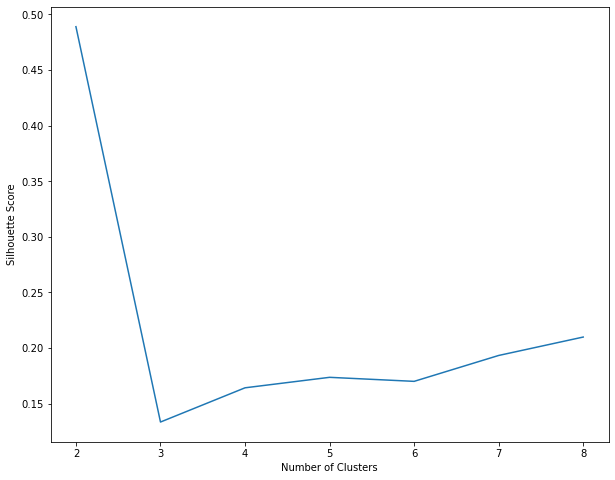

In [81]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(10,8))
ax.plot(range(2,9),silhouette_scores)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')

In [89]:
# K=2 con BisectingKMeans es el valor mas alto
silhouette_scores[0]

0.48900895722575854

### Segmentación de datos usando dos grupos K=2 CON Bisecting Kmeans

In [90]:
BIKMeans_2=BisectingKMeans(featuresCol='standardized', k=2)
BIKMeans_2_fit=BIKMeans_2.fit(data_scale_output)
PRED_BIK=BIKMeans_2_fit.transform(data_scale_output)



In [91]:
PRED_BIK.select('Cuantia Contrato','Valor Total de Adiciones','Porcentaje_Adiciones','prediction').show()

+----------------+------------------------+--------------------+----------+
|Cuantia Contrato|Valor Total de Adiciones|Porcentaje_Adiciones|prediction|
+----------------+------------------------+--------------------+----------+
|         2550000|                       0|                 0.0|         1|
|       227715080|                13725060|                6.03|         1|
|         8800007|                       0|                 0.0|         0|
|         4620000|                       0|                 0.0|         0|
|         6000000|                       0|                 0.0|         0|
|         2338744|                       0|                 0.0|         0|
|        19700000|                       0|                 0.0|         0|
|        10500000|                       0|                 0.0|         0|
|         7446195|                       0|                 0.0|         1|
|        14500000|                       0|                 0.0|         0|
|         45

In [92]:
PRED_BIK.groupBy("prediction").agg(max(col="Cuantia Contrato"), min(col="Cuantia Contrato"),
                              min(col="Porcentaje_Adiciones"),
                              max(col="Porcentaje_Adiciones")).show()

+----------+---------------------+---------------------+-------------------------+-------------------------+
|prediction|max(Cuantia Contrato)|min(Cuantia Contrato)|min(Porcentaje_Adiciones)|max(Porcentaje_Adiciones)|
+----------+---------------------+---------------------+-------------------------+-------------------------+
|         1|           2147423167|              1000000|                      0.0|                   995.69|
|         0|           2145700000|              1000000|                      0.0|                   999.99|
+----------+---------------------+---------------------+-------------------------+-------------------------+



La tabla anterior muestra que la división para dos grupos con BisectingKmeans no tiene en cuenta la cuantia del contrato de los porcentajes en adiciones, por lo cual no son modelos que permitan una buena segmentación de los datos.

In [93]:
PRED_BIK.printSchema()

root
 |-- Tipo de Proceso: string (nullable = true)
 |-- Objeto a Contratar: string (nullable = true)
 |-- Tipo de Contrato: string (nullable = true)
 |-- Nombre de la Entidad: string (nullable = true)
 |-- Nombre Grupo: string (nullable = true)
 |-- Nombre Clase: string (nullable = true)
 |-- Plazo de Ejec del Contrato: integer (nullable = true)
 |-- Rango de Ejec del Contrato: string (nullable = true)
 |-- Cuantia Contrato: integer (nullable = true)
 |-- Valor Total de Adiciones: integer (nullable = true)
 |-- Porcentaje_Adiciones: double (nullable = true)
 |-- Origen de los Recursos: string (nullable = true)
 |-- Municipio Entidad: string (nullable = true)
 |-- Departamento Entidad: string (nullable = true)
 |-- Tipo de ProcesoIndex: double (nullable = false)
 |-- Objeto a ContratarIndex: double (nullable = false)
 |-- Tipo de ContratoIndex: double (nullable = false)
 |-- Nombre de la EntidadIndex: double (nullable = false)
 |-- Nombre GrupoIndex: double (nullable = false)
 |-- Nomb

In [94]:
from pyspark.sql.functions import sum,avg,max

PRED_BIK.groupBy("prediction").count().show()

+----------+-------+
|prediction|  count|
+----------+-------+
|         1|1973610|
|         0|7341899|
+----------+-------+



por medio de clustering con kmeans y bisectingkmeans no se logra una buena segmentacion de los datos que tenga en cuenta la cuantia de los contratos y su porcentaje en adiciones

In [29]:
data_scale_output.printSchema()

root
 |-- Tipo de Proceso: string (nullable = true)
 |-- Objeto a Contratar: string (nullable = true)
 |-- Tipo de Contrato: string (nullable = true)
 |-- Nombre de la Entidad: string (nullable = true)
 |-- Nombre Grupo: string (nullable = true)
 |-- Nombre Clase: string (nullable = true)
 |-- Plazo de Ejec del Contrato: integer (nullable = true)
 |-- Rango de Ejec del Contrato: string (nullable = true)
 |-- Cuantia Contrato: integer (nullable = true)
 |-- Valor Total de Adiciones: integer (nullable = true)
 |-- Porcentaje_Adiciones: double (nullable = true)
 |-- Origen de los Recursos: string (nullable = true)
 |-- Municipio Entidad: string (nullable = true)
 |-- Departamento Entidad: string (nullable = true)
 |-- Tipo de ProcesoIndex: double (nullable = false)
 |-- Objeto a ContratarIndex: double (nullable = false)
 |-- Tipo de ContratoIndex: double (nullable = false)
 |-- Nombre de la EntidadIndex: double (nullable = false)
 |-- Nombre GrupoIndex: double (nullable = false)
 |-- Nomb

In [96]:
data_scale_output.select('Porcentaje_Adiciones').summary().show()

+-------+--------------------+
|summary|Porcentaje_Adiciones|
+-------+--------------------+
|  count|             9315509|
|   mean|   4.017407763762553|
| stddev|   21.08448255600406|
|    min|                 0.0|
|    25%|                 0.0|
|    50%|                 0.0|
|    75%|                 0.0|
|    max|              999.99|
+-------+--------------------+



### Creación variable Grupos
Esta variable divide los datos en los contratos con valores en porcentaje de adiciones <=50% con la clase 0 y los >50% con clase 1.

In [30]:
from pyspark.ml.feature import Bucketizer

bucketizer = Bucketizer(splits=[ 0,50.01,1000],inputCol='Porcentaje_Adiciones', outputCol="Grupos")
df_grupos = bucketizer.setHandleInvalid("keep").transform(data_scale_output)
# Grupo_0 porcentaje adiciones >= 0 y <=50
# Grupo_1 porcentaje adiciones >50



In [100]:
df_grupos.printSchema()

root
 |-- Tipo de Proceso: string (nullable = true)
 |-- Objeto a Contratar: string (nullable = true)
 |-- Tipo de Contrato: string (nullable = true)
 |-- Nombre de la Entidad: string (nullable = true)
 |-- Nombre Grupo: string (nullable = true)
 |-- Nombre Clase: string (nullable = true)
 |-- Plazo de Ejec del Contrato: integer (nullable = true)
 |-- Rango de Ejec del Contrato: string (nullable = true)
 |-- Cuantia Contrato: integer (nullable = true)
 |-- Valor Total de Adiciones: integer (nullable = true)
 |-- Porcentaje_Adiciones: double (nullable = true)
 |-- Origen de los Recursos: string (nullable = true)
 |-- Municipio Entidad: string (nullable = true)
 |-- Departamento Entidad: string (nullable = true)
 |-- Tipo de ProcesoIndex: double (nullable = false)
 |-- Objeto a ContratarIndex: double (nullable = false)
 |-- Tipo de ContratoIndex: double (nullable = false)
 |-- Nombre de la EntidadIndex: double (nullable = false)
 |-- Nombre GrupoIndex: double (nullable = false)
 |-- Nomb

In [106]:
from pyspark.sql.functions import col
df_grupos.select('Porcentaje_Adiciones','Grupos').filter(col('Porcentaje_Adiciones') ==50.01).show()

+--------------------+------+
|Porcentaje_Adiciones|Grupos|
+--------------------+------+
|               50.01|   1.0|
|               50.01|   1.0|
|               50.01|   1.0|
|               50.01|   1.0|
|               50.01|   1.0|
|               50.01|   1.0|
|               50.01|   1.0|
|               50.01|   1.0|
|               50.01|   1.0|
|               50.01|   1.0|
|               50.01|   1.0|
|               50.01|   1.0|
|               50.01|   1.0|
|               50.01|   1.0|
|               50.01|   1.0|
|               50.01|   1.0|
|               50.01|   1.0|
|               50.01|   1.0|
|               50.01|   1.0|
|               50.01|   1.0|
+--------------------+------+
only showing top 20 rows



In [107]:
df_grupos.groupBy("Grupos").count().show()

+------+-------+
|Grupos|  count|
+------+-------+
|   0.0|9246110|
|   1.0|  69399|
+------+-------+



In [108]:
df_grupos.printSchema()

root
 |-- Tipo de Proceso: string (nullable = true)
 |-- Objeto a Contratar: string (nullable = true)
 |-- Tipo de Contrato: string (nullable = true)
 |-- Nombre de la Entidad: string (nullable = true)
 |-- Nombre Grupo: string (nullable = true)
 |-- Nombre Clase: string (nullable = true)
 |-- Plazo de Ejec del Contrato: integer (nullable = true)
 |-- Rango de Ejec del Contrato: string (nullable = true)
 |-- Cuantia Contrato: integer (nullable = true)
 |-- Valor Total de Adiciones: integer (nullable = true)
 |-- Porcentaje_Adiciones: double (nullable = true)
 |-- Origen de los Recursos: string (nullable = true)
 |-- Municipio Entidad: string (nullable = true)
 |-- Departamento Entidad: string (nullable = true)
 |-- Tipo de ProcesoIndex: double (nullable = false)
 |-- Objeto a ContratarIndex: double (nullable = false)
 |-- Tipo de ContratoIndex: double (nullable = false)
 |-- Nombre de la EntidadIndex: double (nullable = false)
 |-- Nombre GrupoIndex: double (nullable = false)
 |-- Nomb

Se deben eliminar las columnas features,standardized, valor total de adiciones y porcentaje de adiciones y luego volver a crear la columna features,standardized y evaluar modelos

In [31]:
df_grupos=df_grupos.drop('Valor Total de Adiciones','Porcentaje_Adiciones','features','standardized')

In [32]:
df_grupos.printSchema()

root
 |-- Tipo de Proceso: string (nullable = true)
 |-- Objeto a Contratar: string (nullable = true)
 |-- Tipo de Contrato: string (nullable = true)
 |-- Nombre de la Entidad: string (nullable = true)
 |-- Nombre Grupo: string (nullable = true)
 |-- Nombre Clase: string (nullable = true)
 |-- Plazo de Ejec del Contrato: integer (nullable = true)
 |-- Rango de Ejec del Contrato: string (nullable = true)
 |-- Cuantia Contrato: integer (nullable = true)
 |-- Origen de los Recursos: string (nullable = true)
 |-- Municipio Entidad: string (nullable = true)
 |-- Departamento Entidad: string (nullable = true)
 |-- Tipo de ProcesoIndex: double (nullable = false)
 |-- Objeto a ContratarIndex: double (nullable = false)
 |-- Tipo de ContratoIndex: double (nullable = false)
 |-- Nombre de la EntidadIndex: double (nullable = false)
 |-- Nombre GrupoIndex: double (nullable = false)
 |-- Nombre ClaseIndex: double (nullable = false)
 |-- Rango de Ejec del ContratoIndex: double (nullable = false)
 |--

### Creación de la variable features un vector con las variables predictoras indexadas

In [33]:
from pyspark.ml.feature import VectorAssembler

assemble=VectorAssembler(inputCols=['Tipo de ProcesoIndex',
        'Objeto a ContratarIndex',
      'Tipo de ContratoIndex',
       'Nombre de la EntidadIndex',
       'Nombre GrupoIndex', 'Nombre ClaseIndex',
       'Plazo de Ejec del Contrato', 'Rango de Ejec del ContratoIndex',
       'Origen de los RecursosIndex',  'Municipio EntidadIndex', 
        'Departamento EntidadIndex','Cuantia Contrato'], outputCol='features')
df_modelos=assemble.transform(df_grupos)

### Estandarización de las Features

In [34]:
from pyspark.ml.feature import StandardScaler

## Standard Scaling
scale = StandardScaler(inputCol="features", outputCol="standardized")
data_scale = scale.fit(df_modelos)
df_modelos = data_scale.transform(df_modelos)


In [35]:
df_modelos.printSchema()

root
 |-- Tipo de Proceso: string (nullable = true)
 |-- Objeto a Contratar: string (nullable = true)
 |-- Tipo de Contrato: string (nullable = true)
 |-- Nombre de la Entidad: string (nullable = true)
 |-- Nombre Grupo: string (nullable = true)
 |-- Nombre Clase: string (nullable = true)
 |-- Plazo de Ejec del Contrato: integer (nullable = true)
 |-- Rango de Ejec del Contrato: string (nullable = true)
 |-- Cuantia Contrato: integer (nullable = true)
 |-- Origen de los Recursos: string (nullable = true)
 |-- Municipio Entidad: string (nullable = true)
 |-- Departamento Entidad: string (nullable = true)
 |-- Tipo de ProcesoIndex: double (nullable = false)
 |-- Objeto a ContratarIndex: double (nullable = false)
 |-- Tipo de ContratoIndex: double (nullable = false)
 |-- Nombre de la EntidadIndex: double (nullable = false)
 |-- Nombre GrupoIndex: double (nullable = false)
 |-- Nombre ClaseIndex: double (nullable = false)
 |-- Rango de Ejec del ContratoIndex: double (nullable = false)
 |--

### División en datos de entrenamiento y test para clases no balanceadas

In [114]:
# set seed for reproducibility
(trainingData, testData) = df_modelos.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 6520718


Test Dataset Count: 2794791


### Modelo regresión logística

In [116]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'standardized', labelCol = 'Grupos',family="binomial")
lrModel = lr.fit(trainingData)
predic_lr = lrModel.transform(testData)


In [118]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
eval = BinaryClassificationEvaluator(rawPredictionCol = "prediction", labelCol = "Grupos",metricName='areaUnderROC')
auc = eval.evaluate(predic_lr)
print(auc)

0.5


In [119]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="Grupos", predictionCol="prediction", metricName="accuracy")
evaluator.evaluate(predic_lr)

0.9925074898266095

In [120]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="Grupos", predictionCol="prediction", metricName="f1")
evaluator.evaluate(predic_lr)

0.9887753219413389

In [122]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="Grupos", predictionCol="prediction", metricName="precisionByLabel")
evaluator.evaluate(predic_lr)

0.9925074898266095

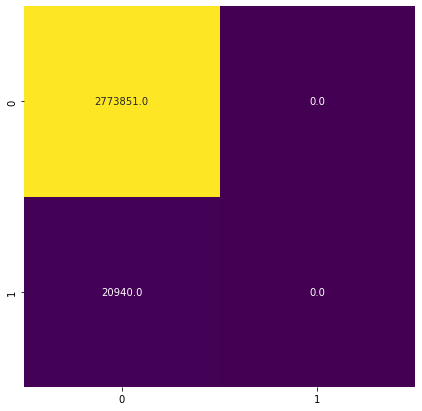

In [123]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType
#select only prediction and label columns
labels = [0, 1]

# important: need to cast to float type, and order by prediction, else it won't work
preds_and_labels = predic_lr.select(['prediction','Grupos']).withColumn('Grupos', col('Grupos').cast(FloatType())).orderBy('prediction')
# generate metrics
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

# figure object
_ = plt.figure(figsize=(7, 7))

# plot confusion matrix
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)
plt.show()



In [124]:
metrics.precision(1.0)

0.0

Para este modelo se tiene un pésimo desempeño evaluando la clase 1 debido a que las clases no están balanceadas y se predice la mayoría como clase 0.

### Modelo Naive Bayes

In [125]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(smoothing=1,labelCol="Grupos", featuresCol='standardized')
model = nb.fit(trainingData)
pred_nb = model.transform(testData)

In [127]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
eval = BinaryClassificationEvaluator(rawPredictionCol = "prediction", labelCol = "Grupos",metricName='areaUnderROC')
auc = eval.evaluate(pred_nb)
print(auc)


0.5491060608477307


In [128]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="Grupos", predictionCol="prediction", metricName='f1')
evaluator.evaluate(pred_nb)

0.8085878913440622

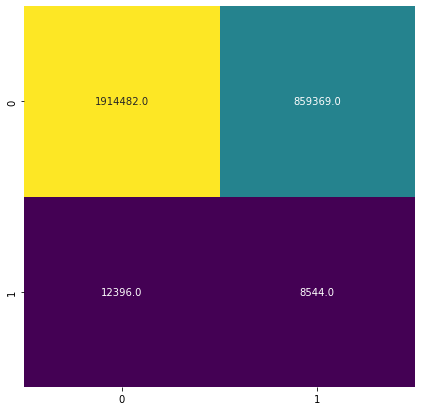

In [129]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType
#select only prediction and label columns
labels = [0, 1]

# important: need to cast to float type, and order by prediction, else it won't work
preds_and_labels = pred_nb.select(['prediction','Grupos']).withColumn('Grupos', col('Grupos').cast(FloatType())).orderBy('prediction')
# generate metrics
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

# figure object
_ = plt.figure(figsize=(7, 7))

# plot confusion matrix
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)
plt.show()


In [130]:
metrics.precision(1.0)

0.009844304671090305

Para este modelo se tiene un pésimo desempeño evaluando la clase 1 debido a que las clases no están balanceadas y se predice la mayoría como clase 0.

## Balanceo de clases

### Balanceo de la clase 0

Se realiza un muestreo con una menor fraccion del grupo cero que es el mas abundante

In [36]:
s_data=df_modelos.sampleBy("Grupos", fractions={0:0.50,1:1},seed=1234 )

In [37]:
s_data.groupBy("Grupos").count().show()

+------+-------+
|Grupos|  count|
+------+-------+
|   0.0|4623049|
|   1.0|  69399|
+------+-------+



### Balanceo de la clase 1

In [38]:
from pyspark.sql.functions import col
g1 = s_data.filter(col("Grupos") == 1)
g0=s_data.filter(col("Grupos") == 0)

In [39]:
# numero de veces de la clase 1 en la clase 0
r1=int(4623049/69399)


In [40]:
from pyspark.sql.functions import col, explode, array, lit
a = range(r1)# duplicate the minority rows
oversampled_g1 = g1.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
# combine both oversampled minority rows and previous majority rows 
combined_df = g0.unionAll(oversampled_g1)


In [41]:
combined_df.groupBy("Grupos").count().show()

+------+-------+
|Grupos|  count|
+------+-------+
|   0.0|4623049|
|   1.0|4580334|
+------+-------+



Al final del proceso los datos se encuentran lo suficientemente balanceados para efectuar la evaluación de modelos.

### División en datos de entrenamiento y datos de test

In [42]:
# set seed for reproducibility
(trainingData, testData) = combined_df.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 6443635


Test Dataset Count: 2759748


## Evaluación de modelos con clases balanceadas

Primero se observa el desempeño de los modelos usando la métrica AUC que presenta resultados mas robustos, para posteriormente evaluar los mejores modelos con las principales métricas y buscar el mejor modelo.

### Modelo regresión logística 

In [139]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(family="binomial",featuresCol = 'standardized', labelCol = 'Grupos')
lrModel = lr.fit(trainingData)
predictions = lrModel.transform(testData)


In [140]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
eval = BinaryClassificationEvaluator(rawPredictionCol = "prediction", labelCol = "Grupos",metricName='areaUnderROC')
auc = eval.evaluate(predictions)
print(auc)

0.6752779554657126


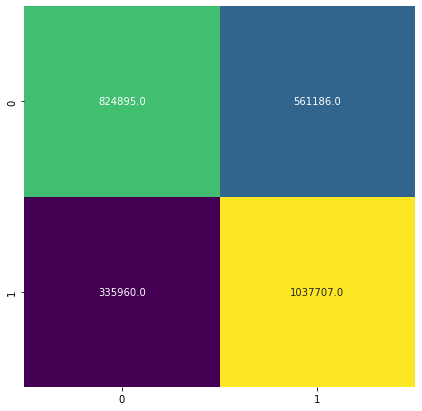

In [141]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType
#select only prediction and label columns
labels = [0, 1]

# important: need to cast to float type, and order by prediction, else it won't work
preds_and_labels = predictions.select(['prediction','Grupos']).withColumn('Grupos', col('Grupos').cast(FloatType())).orderBy('prediction')
# generate metrics
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

# figure object
_ = plt.figure(figsize=(7, 7))

# plot confusion matrix
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)
plt.show()

In [142]:
metrics.precision(1.0)

0.6490159128847272

In [143]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="Grupos", predictionCol="prediction", metricName="accuracy")
evaluator.evaluate(predictions)

0.6749174199963185

### Modelo Naive Bayes

In [146]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(smoothing=1,labelCol="Grupos", featuresCol='standardized')
model = nb.fit(trainingData)
pred_nb = model.transform(testData)

In [147]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
eval = BinaryClassificationEvaluator(rawPredictionCol = "prediction", labelCol = "Grupos",metricName='areaUnderROC')
auc = eval.evaluate(pred_nb)
print(auc)

0.6847677609931306


In [148]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="Grupos", predictionCol="prediction", metricName='accuracy')
evaluator.evaluate(pred_nb)

0.6846472938833545

In [149]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="Grupos", predictionCol="prediction", metricName='f1')
evaluator.evaluate(pred_nb)

0.6844364140803022

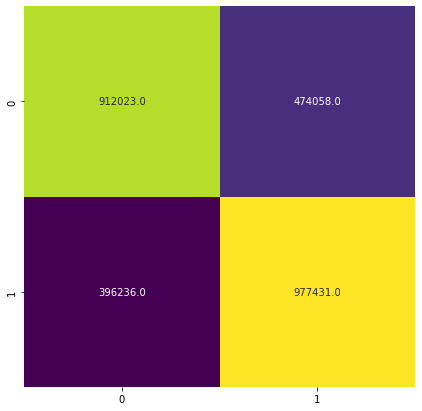

In [150]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType
#select only prediction and label columns
labels = [0, 1]

# important: need to cast to float type, and order by prediction, else it won't work
preds_and_labels = pred_nb.select(['prediction','Grupos']).withColumn('Grupos', col('Grupos').cast(FloatType())).orderBy('prediction')
# generate metrics
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

# figure object
_ = plt.figure(figsize=(7, 7))

# plot confusion matrix
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)
plt.show()

In [161]:
metrics.precision(1.0)

0.6733988338871325

Se decide evaluar varios modelos para regresión logística y para Naive Bayes

### Se evalúan varios modelos para Naive Bayes

In [166]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator
nb = NaiveBayes(labelCol="Grupos", featuresCol='standardized')


paramGrid_nb = ParamGridBuilder().addGrid(nb.smoothing, np.linspace(0.3, 10, 10)).build()
    
crossval_nb = CrossValidator(estimator=nb,estimatorParamMaps=paramGrid_nb,evaluator=BinaryClassificationEvaluator(labelCol = "Grupos"),numFolds= 5) 


In [167]:
cvModel_nb = crossval_nb.fit(trainingData)

In [168]:
cvModel_nb.avgMetrics

[0.6421335623305158,
 0.6421285438632621,
 0.6421280909203378,
 0.6421316310967833,
 0.6421286454223548,
 0.6421231293857297,
 0.6421286877014809,
 0.6421307686980706,
 0.6421222507847977,
 0.64212984084086]

In [ ]:
predictions_nb = cvModel_nb.transform(testData)

### Se evalúan varios modelos para regresión logística

In [169]:
lr = LogisticRegression(maxIter = 10,featuresCol = 'standardized', labelCol = 'Grupos')

paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, np.linspace(0.3, 0.01, 10)) \
    .addGrid(lr.elasticNetParam, np.linspace(0.3, 0.8, 6)) \
    .build()
crossval_lr = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid_lr,
                          evaluator=BinaryClassificationEvaluator(labelCol = "Grupos"),
                          numFolds= 5)  

In [170]:
cvModel_lr = crossval_lr.fit(trainingData)

In [171]:
predictions_lr = cvModel_lr.transform(testData)

In [177]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
eval = BinaryClassificationEvaluator(rawPredictionCol = "prediction", labelCol = "Grupos",metricName='areaUnderROC')
auc_lr = eval.evaluate(predictions_lr)
print(auc_lr)

0.6744157168027388


No se observa una mejora significativa en el desempeño de los modelos anteriores

### Modelo Arboles de decisión profundidad máxima 4

In [173]:
from pyspark.ml.classification import DecisionTreeClassifier
params = {'maxDepth':4}

dTree_classifier = DecisionTreeClassifier(**params, seed= 13,featuresCol = 'standardized', labelCol = 'Grupos')
dTree_classifier

DecisionTreeClassifier_a18f4fd2e918

In [174]:
dTree_model = dTree_classifier.fit(trainingData)

In [175]:
predictionAndLabels = dTree_model.transform(testData)

In [178]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
eval = BinaryClassificationEvaluator(rawPredictionCol = "prediction", labelCol = "Grupos",metricName='areaUnderROC')
auc_dc = eval.evaluate(predictionAndLabels)
print(auc_dc)

0.766248952032011


Debido a los buenos resultados del modelo de arboles de decisión se decide hacer 3 modelos cambiando el parámetro maxdepth con 20, 24 y 30 respectivamente, para observar la mejora en las métricas.

### Modelo 1 Arboles de decisión profundidad máxima 20

In [43]:
from pyspark.ml.classification import DecisionTreeClassifier
params_1 = {'maxDepth':20}

dTree_classifier_1 = DecisionTreeClassifier(**params_1, seed= 13,featuresCol = 'standardized', labelCol = 'Grupos')
dTree_classifier_1

DecisionTreeClassifier_97cc20aa513f

In [44]:
dTree_model_1 = dTree_classifier_1.fit(trainingData)

In [45]:
predictionAndLabels_1 = dTree_model_1.transform(testData)

In [46]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
eval = BinaryClassificationEvaluator(rawPredictionCol = "prediction", labelCol = "Grupos",metricName='areaUnderROC')
auc_dc1 = eval.evaluate(predictionAndLabels_1)
print(auc_dc1)

0.9370594399178828


In [193]:
#confusion matrix
cm_dt_result = predictionAndLabels_1.crosstab("prediction", "Grupos")
cm_dt_result = cm_dt_result.toPandas()
cm_dt_result.sort_values(by = ['prediction_Grupos'])

,prediction_Grupos,0.0,1.0
1,0.0,1290364,78059
0,1.0,95717,1295608


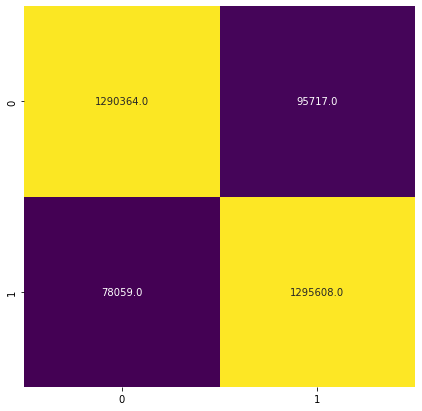

In [47]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType
#select only prediction and label columns
labels = [0, 1]

# important: need to cast to float type, and order by prediction, else it won't work
preds_and_labels = predictionAndLabels_1.select(['prediction','Grupos']).withColumn('Grupos', col('Grupos').cast(FloatType())).orderBy('prediction')
# generate metrics
metrics_20 = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

# figure object
_ = plt.figure(figsize=(7, 7))

# plot confusion matrix
sns.heatmap(metrics_20.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)
plt.show()

In [54]:
import pyspark.sql.functions as F
def classification_report_pyspark(metrics_multiclass,preds_and_labels, labels_list):
    #import math
    columns = ['target_class', 'precision', 'recall', 'f1-score', 'support']

    data = []
    for i in labels_list:
        support = preds_and_labels.where('Grupos = ' + str(i)).count()
        data.append((str(i), float(np.round(metrics_multiclass.precision(label = i),3)), 
                     float(np.round(metrics_multiclass.recall(label = i), 3)), 
                     float(np.round(metrics_multiclass.fMeasure(i), 3)), support)), 

    data.append(('weighted avg', float(np.round(metrics_multiclass.weightedPrecision, 3)), 
                                 float(np.round(metrics_multiclass.weightedRecall, 3)), 
                                   float(np.round(metrics_multiclass.weightedFMeasure(), 3)), preds_and_labels.count() ))
    class_rep = spark.createDataFrame(data, columns)
    return class_rep

In [55]:
class_rep = classification_report_pyspark(metrics_20, preds_and_labels, [0.0, 1.0])

In [56]:
class_rep.show()

+------------+---------+------+--------+-------+
|target_class|precision|recall|f1-score|support|
+------------+---------+------+--------+-------+
|         0.0|    0.943| 0.931|   0.937|1386081|
|         1.0|    0.931| 0.943|   0.937|1373667|
|weighted avg|    0.937| 0.937|   0.937|2759748|
+------------+---------+------+--------+-------+



In [57]:
print("Accuracy: ",metrics_20.accuracy)

Accuracy:  0.9370319319010286


### Modelo 2 Arboles de decisión profundidad máxima 24 

In [58]:
from pyspark.ml.classification import DecisionTreeClassifier
params_2 = {'maxDepth':24}

dTree_classifier_2 = DecisionTreeClassifier(**params_2, seed= 13,featuresCol = 'standardized', labelCol = 'Grupos')
dTree_classifier_2

DecisionTreeClassifier_51310176d572

In [59]:

dTree_model_2 = dTree_classifier_2.fit(trainingData)

In [60]:
predictionAndLabels_2 = dTree_model_2.transform(testData)

In [61]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
eval = BinaryClassificationEvaluator(rawPredictionCol = "prediction", labelCol = "Grupos",metricName='areaUnderROC')
auc_dc2 = eval.evaluate(predictionAndLabels_2)
print(auc_dc2)

0.9632301981717973


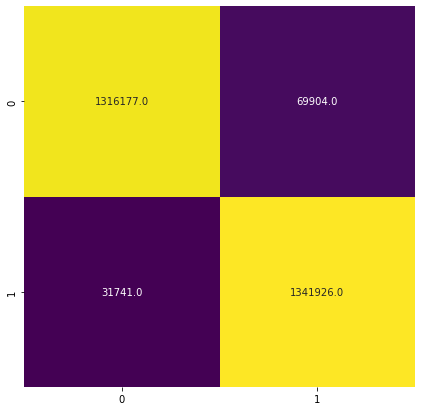

In [62]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType
#select only prediction and label columns
labels = [0, 1]

# important: need to cast to float type, and order by prediction, else it won't work
preds_and_labels = predictionAndLabels_2.select(['prediction','Grupos']).withColumn('Grupos', col('Grupos').cast(FloatType())).orderBy('prediction')
# generate metrics
metrics_24 = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

# figure object
_ = plt.figure(figsize=(7, 7))

# plot confusion matrix
sns.heatmap(metrics_24.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)
plt.show()

In [63]:
class_rep = classification_report_pyspark(metrics_24, preds_and_labels, [0.0, 1.0])

In [64]:
class_rep.show()

+------------+---------+------+--------+-------+
|target_class|precision|recall|f1-score|support|
+------------+---------+------+--------+-------+
|         0.0|    0.976|  0.95|   0.963|1386081|
|         1.0|     0.95| 0.977|   0.964|1373667|
|weighted avg|    0.964| 0.963|   0.963|2759748|
+------------+---------+------+--------+-------+



In [65]:
print("Accuracy: ",metrics_24.accuracy)

Accuracy:  0.9631687385949732


### Modelo 3 Arboles de decisión profundidad máxima 30 

In [66]:
from pyspark.ml.classification import DecisionTreeClassifier
params_3 = {'maxDepth':30}

dTree_classifier_3 = DecisionTreeClassifier(**params_3, seed= 13,featuresCol = 'standardized', labelCol = 'Grupos')
dTree_classifier_3

DecisionTreeClassifier_171b16bad13d

In [67]:
dTree_model_3 = dTree_classifier_3.fit(trainingData)

In [68]:
predictionAndLabels_3 = dTree_model_3.transform(testData)

In [69]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
eval = BinaryClassificationEvaluator(rawPredictionCol = "prediction", labelCol = "Grupos",metricName='areaUnderROC')
auc_dc3 = eval.evaluate(predictionAndLabels_3)
print(auc_dc3)

0.97702259496923


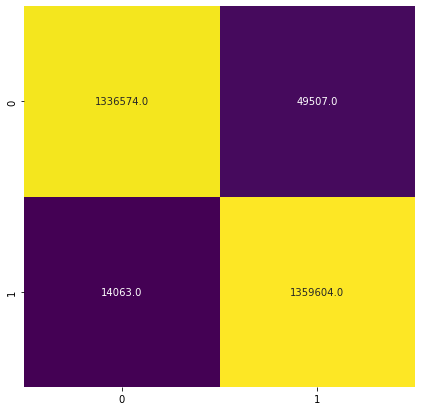

In [70]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType
#select only prediction and label columns
labels = [0, 1]

# important: need to cast to float type, and order by prediction, else it won't work
preds_and_labels = predictionAndLabels_3.select(['prediction','Grupos']).withColumn('Grupos', col('Grupos').cast(FloatType())).orderBy('prediction')
# generate metrics
metrics_30 = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

# figure object
_ = plt.figure(figsize=(7, 7))

# plot confusion matrix
sns.heatmap(metrics_30.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)
plt.show()

In [71]:
class_rep = classification_report_pyspark(metrics_30, preds_and_labels, [0.0, 1.0])

In [72]:
class_rep.show()

+------------+---------+------+--------+-------+
|target_class|precision|recall|f1-score|support|
+------------+---------+------+--------+-------+
|         0.0|     0.99| 0.964|   0.977|1386081|
|         1.0|    0.965|  0.99|   0.977|1373667|
|weighted avg|    0.977| 0.977|   0.977|2759748|
+------------+---------+------+--------+-------+



In [75]:
print("Accuracy: ",metrics_30.accuracy)

Accuracy:  0.9769652881350036


### Mejor modelo

EL mejor modelo es el modelo con 30 de max depth usando arboles de decisión


Qué porcentaje de predicciones fue correcta?

La exactitud (accuracy) es (0.97) es decir el 97% de las predicciones fueron correctas

¿Qué porcentaje de predicciones positivas fueron correctas? 

La precisión (precisión) 97% para los contratos que tienen adiciones en porcentaje superior al 50% de la cuantiá del contrato y de 99% para los contratos con adiciones inferiores o iguales al 50% de la cuantiá del contrato. El modelo es levemente mas preciso para los contratos sin adiciones superiores al 50%.

¿Qué porcentaje de casos positivos fueron capturados? 

La recuperación (recall) 99% para los contratos que tienen adiciones en porcentaje superior al 50% de la cuantiá del contrato y de 97% para los contratos con adiciones inferiores o iguales al 50% de la cuantiá del contrato. El modelo es levemente mejor para capturar los contratos con adiciones superiores al 50%.

El f1-score hace un balance entre precisión y recall cuando los valores de precisión y recall son más altos mutuamente, el valor de f1-score tiende a ser más alto. Tenemos un f1 general de 97% por lo que el modelo es muy bueno para separar las dos clases correctamente.


El AUC es 0.98 significa que hay 98% de probabilidad de que el modelo pueda distinguir entre la clase positiva y clase negativa.

Este modelo presenta un recall mejor que los modelos anteriores identificando mejor los contratos que exceden el 50% en adiciones de la cuantiá del contrato con una mejora de 97 a 99% comparado con el modelo anterior, por otra parte todas las métricas son lo suficientemente altas mostrando un modelo bastante robusto y adecuado para realizar las predicciones.

In [77]:
dat=['Tipo de Proceso',
 'Objeto a Contratar',
 'Tipo de Contrato',
 'Nombre de la Entidad',
 'Nombre Grupo',
 'Nombre Clase',
 'Plazo de Ejec del Contrato',
 'Rango de Ejec del Contrato',
 'Cuantia Contrato',
 'Origen de los Recursos',
 'Municipio Entidad',
 'Departamento Entidad']

### Variables mas importantes

In [78]:
feature_imp = dict(zip(dat, np.round(dTree_model_3.featureImportances.toArray()*100,2)))
feature_imp

{'Tipo de Proceso': 6.09,
 'Objeto a Contratar': 8.65,
 'Tipo de Contrato': 2.82,
 'Nombre de la Entidad': 18.78,
 'Nombre Grupo': 0.99,
 'Nombre Clase': 5.44,
 'Plazo de Ejec del Contrato': 10.85,
 'Rango de Ejec del Contrato': 1.18,
 'Cuantia Contrato': 2.65,
 'Origen de los Recursos': 25.68,
 'Municipio Entidad': 4.82,
 'Departamento Entidad': 12.05}

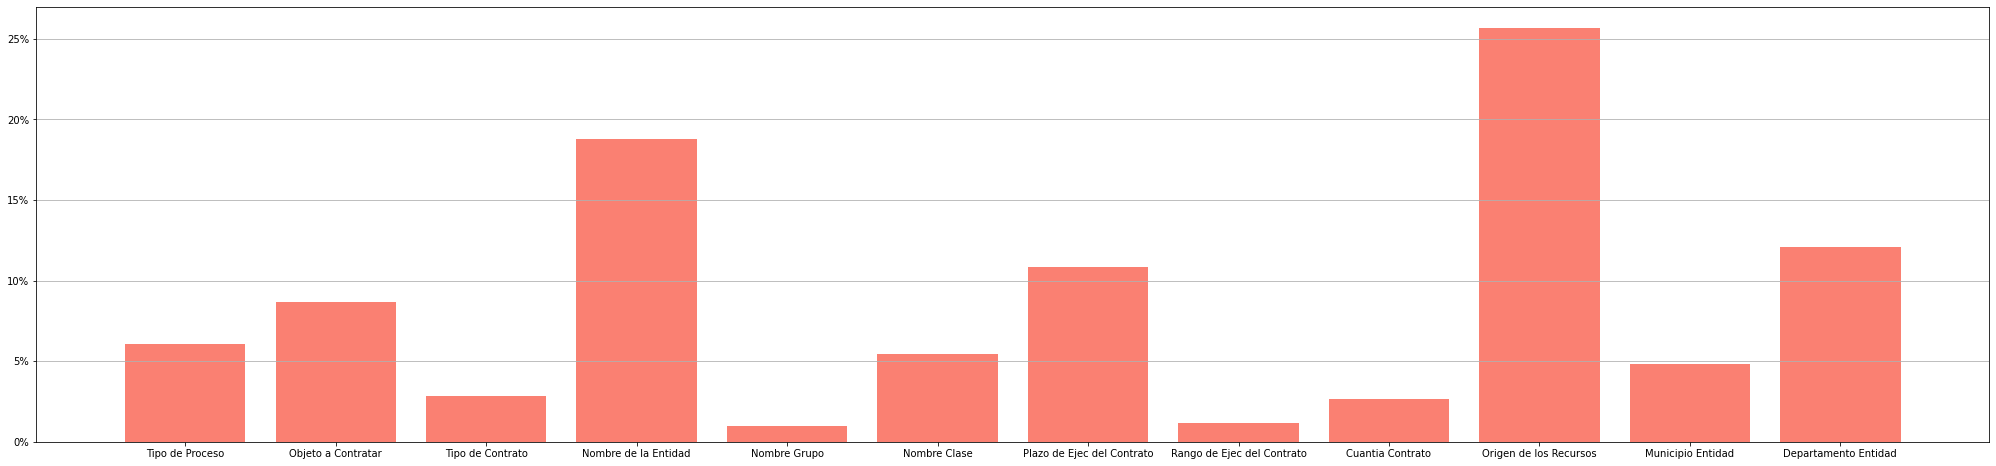

In [116]:
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
plt.figure(figsize= (35,8))
total = np.sum(list(feature_imp.values()))
plt.bar(feature_imp.keys(), [v/total for v in feature_imp.values()], color='salmon')
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.grid(axis='y')
plt.show()

Para este modelo la variable mas importante es el origen de los recursos, seguida del nombre de la entidad, el departamento de la entidad, el plazo de ejecucion del contrato, el objeto a contratar, el tipo de proceso, el nombre de la clase, el municipio de la entidad y en menor medida de importancia el tipo de contrato, la cuantia del contrato, el rango de ejecucion del contrato, y el nombre de grupo.

### Feature Pipeline

In [84]:
data_train=trainingData.select(dat)

In [85]:
data_train.printSchema()

root
 |-- Tipo de Proceso: string (nullable = true)
 |-- Objeto a Contratar: string (nullable = true)
 |-- Tipo de Contrato: string (nullable = true)
 |-- Nombre de la Entidad: string (nullable = true)
 |-- Nombre Grupo: string (nullable = true)
 |-- Nombre Clase: string (nullable = true)
 |-- Plazo de Ejec del Contrato: integer (nullable = true)
 |-- Rango de Ejec del Contrato: string (nullable = true)
 |-- Cuantia Contrato: integer (nullable = true)
 |-- Origen de los Recursos: string (nullable = true)
 |-- Municipio Entidad: string (nullable = true)
 |-- Departamento Entidad: string (nullable = true)



In [86]:

feature_pipe = Pipeline(stages=[partPipeline,assemble,scale]).fit(data_train)


#### Se guarda el modelo

In [ ]:
feature_pipe = Pipeline(stages=[partPipeline,assemble,scale]).fit(data_train)



In [89]:

#Save the model

feature_pipe_model.save('pipeline_model')

#Save the model

dTree_model_3.save('model_dct')